# Classfication Evaluation

In [196]:
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../modules/'))
sys.path.insert(1, os.path.join(sys.path[0], '../data_creation/'))
sys.path.insert(1, os.path.join(sys.path[0], '../networks/'))
sys.path.insert(1, os.path.join(sys.path[0], '../network_trainers/'))

from CNN_DS_BN_C import CNN_DS_BN_C
from CNN_DS_BN_BC import CNN_DS_BN_BC
from Data_Creator_C import Data_Creator_C
from data_manipulation import *
import tensorflow as tf

In [3]:
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [4]:
_, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())
# training_baselines_data = get_seps_data(training_redundant_baselines_dict, uvd)
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

## Load in data

In [5]:
def make_A_from_list_o_sep_pairs(list_o_sep_pairs, max_ant): 
    def get_A_row(two_seps, max_ant_idx):
        """Contructs a row of A by placing a 1 or -1 in the index corresponding to an antenna"""

        a = np.array(two_seps).flatten()

        b = np.zeros((a.size, max_ant_idx), dtype = int)

        b[np.arange(a.size),a] = 1
        b[1] *= -1
        b[2] *= -1

        return np.sum(b, axis = 0)
    
    max_ant_idx = max_ant + 1
    A = []
    for two_seps in list_o_sep_pairs:
        
        A.append(get_A_row(two_seps, max_ant_idx = max_ant_idx))

    return np.asarray(A).reshape(-1, max_ant_idx)

In [6]:
# Find all the different antennas for this data set and extract the max value
unique_ants = []
# for sep_pair in evaluation_seps:     
for key in testing_redundant_baselines_dict.keys():
    for sep in testing_redundant_baselines_dict[key]:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)
max_ant = np.max(unique_ants)       

In [7]:
generated_ant_delays = {ant : np.random.uniform(low = -0.010, high = 0.010) for ant in unique_ants}

In [8]:
_bl_data = testing_baselines_data

In [9]:
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [10]:
_bl_dict = testing_redundant_baselines_dict

In [11]:
_gains = gains

In [12]:
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

In [13]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [14]:
def get_target(two_seps, d):
    return np.sum([d[ant] for ant in np.array(two_seps).flatten()])

In [77]:
num_V_ratios = 5000
inputs = []
targets = []
evaluation_seps = []
nu = np.arange(1024)
for i in range(num_V_ratios):
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    evaluation_seps.append(two_seps)
        
    
    target = get_target(two_seps, generated_ant_delays)
    targets.append(target)

    input_rect = np.angle(_flatness(two_seps)*np.exp(-2j*np.pi*(nu*target + np.random.uniform())))
    
    
    inputs.append(input_rect[np.random.randint(60)])

In [78]:
classes = np.arange(0,0.04 + 0.0001, 0.0001)

In [79]:
rounded_targets = np.asarray([np.round(abs(np.round(d * 100,2)/100), 5) for d in targets]).reshape(-1)

In [80]:
eye = np.eye(len(classes), dtype = int)
classes_labels = {}
for i, key in enumerate(classes):
    classes_labels[np.round(key,5)] = eye[i].tolist()


labels = [classes_labels[x] for x in rounded_targets]

***

## Evaluate magnitude of delay

In [81]:
network = CNN_DS_BN_C('CNN_DS_BN_C_2_401_aug7_e_evaluation_test', 3, 401)
network.load_params('../logs/CNN_DS_BN_C_2_401_aug7_e/params/CNN_DS_BN_C')
network.print_params()

params loaded{'adam_initial_learning_rate': 0.0001,
 'log_dir': '../logs/',
 'name': 'CNN_DS_BN_C_2_401_aug7_e_evaluation_test',
 'num_classes': 401,
 'num_downsamples': 3}


In [82]:
network.create_graph()

saver = tf.train.Saver()
with tf.Session() as session:

    saver.restore(session,'../logs/CNN_DS_BN_C_2_401_aug7_e/trained_model.ckpt-1000')
   
    eval_feed_dict = {network.X: np.array(inputs).reshape(-1,1,1024,1),
                      network.sample_keep_prob : 1.,
                      network.conv_keep_prob : 1.,
                      network.is_training : False}

    predicted_labels = session.run([network.predictions], feed_dict = eval_feed_dict)

network Ready - 3381405 trainable parametersINFO:tensorflow:Restoring parameters from ../logs/CNN_DS_BN_C_2_401_aug7_e/trained_model.ckpt-1000


***
## Evaluate sign of delay

In [83]:
network_pos_neg = CNN_DS_BN_BC('positive_negative_classifier_cm_evaluation_test', 2)
network_pos_neg.load_params('../logs/positive_negative_classifier_cm_extended/params/CNN_DS_BN_BC')

network_pos_neg.create_graph()
saver_pos_neg = tf.train.Saver()
with tf.Session() as session_pos_neg:

    saver_pos_neg.restore(session_pos_neg,'../logs/positive_negative_classifier_cm_extended/trained_model.ckpt-1000')
    

    eval_feed_dict_pos_neg = {network_pos_neg.X: np.array(inputs).reshape(-1,1,1024,1),
                              network_pos_neg.sample_keep_prob : 1.,
                              network_pos_neg.downsample_keep_prob : 1.,
                              network_pos_neg.is_training : False}

    predicted_labels_pos_neg = session_pos_neg.run([network_pos_neg.predictions], feed_dict = eval_feed_dict_pos_neg)

creating network graph .... ...... doneINFO:tensorflow:Restoring parameters from ../logs/positive_negative_classifier_cm_extended/trained_model.ckpt-1000


### make a dictionary of : 
 {true_delay, top_guesses, probabilites_for_each_guess, {sign_of_guess : probability_of_sign}}

In [304]:
top_num = 3
evaluations = []
# predicted_label_top_picks =  []

for i, a in enumerate(np.array(predicted_labels).reshape(-1,401)):
    
    ind = np.argpartition(a, -top_num)[-top_num:]
    
    picks = []
    percs = []
    for j in ind:
        
        picks.append(classes[j])#np.round(classes[j],5))
        percs.append(np.round(a[j],5))
        
    idx = np.argsort(percs)
    sPerc = predicted_labels_pos_neg[0][i]
    s = {"pos" : np.round(np.max(sPerc),4)} if np.argmax(sPerc) == 0 else {"neg" : np.round(np.max(sPerc),4)}
    
#     predicted_label_top_picks.append((np.round(evaluation_targets[i],6), np.array(picks)[idx][::-1], np.array(percs)[idx][::-1], s))
    
    evaluation = {}
    evaluation['_true'] = targets[i]#np.round(evaluation_targets[i],6)
    evaluation['top_3'] = [x for x in np.array(picks)[idx][::-1]]
    evaluation['top_3_probs'] = [x for x in np.array(percs)[idx][::-1]]
    evaluation['sign'] = s
#     evaluation['_guess'] = evaluation['top_3'][0] if s.keys()[0] == 'pos' else -1*evaluation['top_3'][0]
#     if np.random.uniform() < 0.90:
#         fake_sign = np.sign(evaluation['_true'])
#     else:
#         fake_sign = -np.sign(evaluation['_true'])
    fake_sign = np.sign(evaluation['_true'])
    evaluation['_guess'] = evaluation['top_3'][0] *fake_sign
    evaluation['error'] = np.abs(evaluation['_true'] - evaluation['_guess'])
    evaluation['sign_error'] = True if evaluation['_true'] > 0 and s.keys()[0] == 'pos' else False
    evaluations.append(evaluation)
                                      

### Print some to take a look

In [305]:
from pprint import pprint as pPrint

In [306]:
for x in evaluations[0:5]:
    pPrint(x)
    print('\n')

{'_guess': -0.0135,
 '_true': -0.013659548897590617,
 'error': 0.0001595488975906171,
 'sign': {'neg': 1.0},
 'sign_error': False,
 'top_3': [0.0135, 0.0134, 0.013300000000000001],
 'top_3_probs': [0.04854, 0.04843, 0.04775]}


{'_guess': 0.0089,
 '_true': 0.008672536235439853,
 'error': 0.00022746376456014676,
 'sign': {'neg': 0.9854},
 'sign_error': False,
 'top_3': [0.0089, 0.009000000000000001, 0.0091],
 'top_3_probs': [0.04092, 0.04076, 0.04043]}


{'_guess': 0.0055000000000000005,
 '_true': 0.005616092192473845,
 'error': 0.00011609219247384409,
 'sign': {'neg': 0.899},
 'sign_error': False,
 'top_3': [0.0055000000000000005, 0.0054, 0.0056],
 'top_3_probs': [0.0441, 0.04385, 0.04376]}


{'_guess': 0.0213,
 '_true': 0.02089130122778618,
 'error': 0.00040869877221381967,
 'sign': {'pos': 0.931},
 'sign_error': True,
 'top_3': [0.0213, 0.0212, 0.021400000000000002],
 'top_3_probs': [0.04036, 0.04029, 0.04009]}


{'_guess': 0.007500000000000001,
 '_true': 0.007768875593680873,
 'erro

In [307]:
errors = [x['error'] for x in evaluations]
sign_errors = [x['sign_error'] for x in evaluations]
best_guesses = [x['_guess'] for x in evaluations]
combined_prob = [x['top_3_probs'][0]*x['sign'].values()[0] for x in evaluations]

In [308]:
print(1 - np.mean(sign_errors))

0.7556


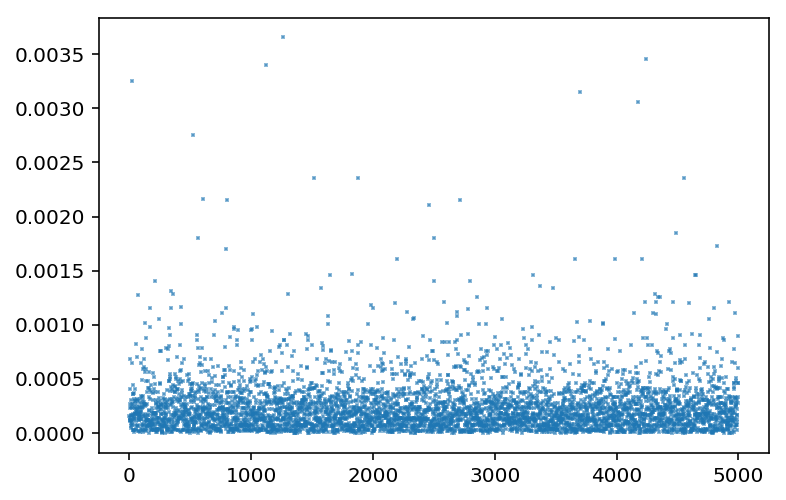

std(error) = 0.000258039948585
percent of errors less than 0.0001 (~1ns)= 0.286
percent of errors less than 0.0005 (~5ns)= 0.9022
percent of errors less than 0.00075 (~7.5ns)= 0.96


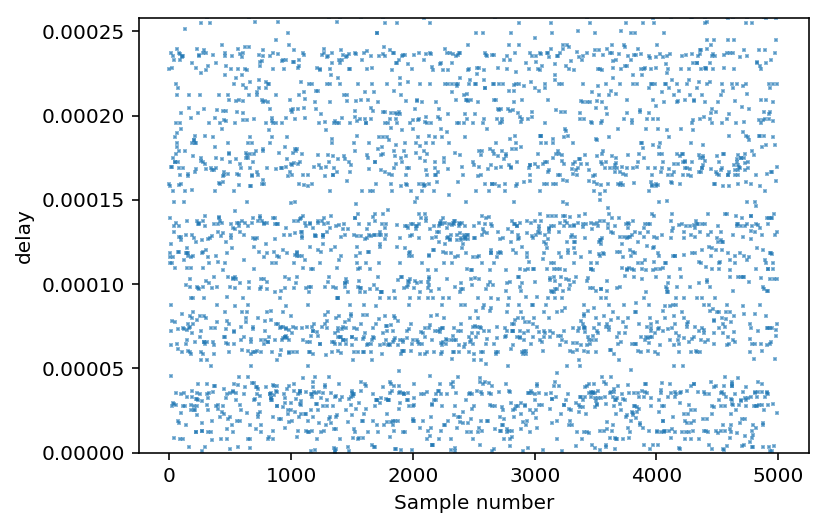

In [309]:
plt.plot(errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)
plt.show()
print('std(error) = {}'.format(np.std(errors)))
print('percent of errors less than 0.0001 (~1ns)= {}'.format(np.mean(np.asarray(errors) < 0.0001)))
print('percent of errors less than 0.0005 (~5ns)= {}'.format(np.mean(np.asarray(errors) < 0.0005)))
print('percent of errors less than 0.00075 (~7.5ns)= {}'.format(np.mean(np.asarray(errors) < 0.00075)))


plt.xlabel('Sample number')
plt.ylabel('delay')
plt.plot(errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)
plt.ylim(0, np.std(errors))
plt.xlabel('Sample number')
plt.ylabel('delay')
plt.show()

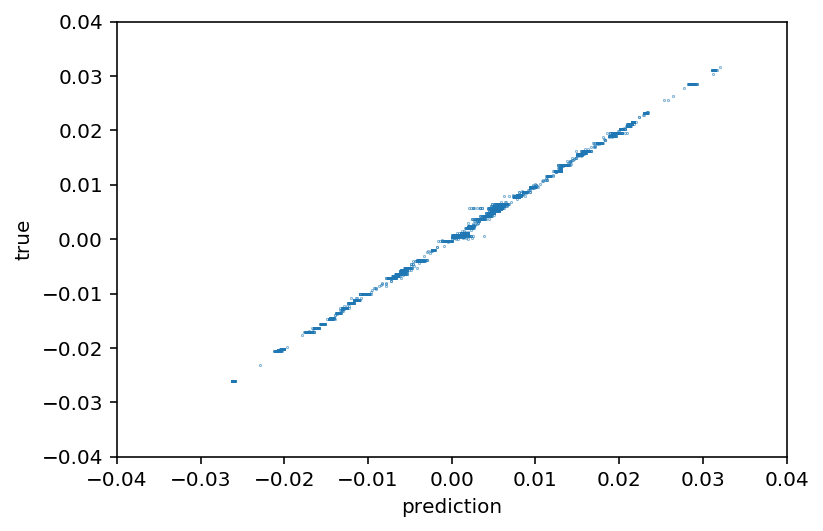

In [310]:
# fig, ax = plt.subplots(figsize = (8,5), dpi = 144)
plt.plot(best_guesses, targets, ls = 'none', marker = 's', markersize = .1, alpha = 1);
plt.xlim(-0.040, 0.040)
plt.ylim(-0.040, 0.040)
plt.xlabel('prediction')
plt.ylabel('true');

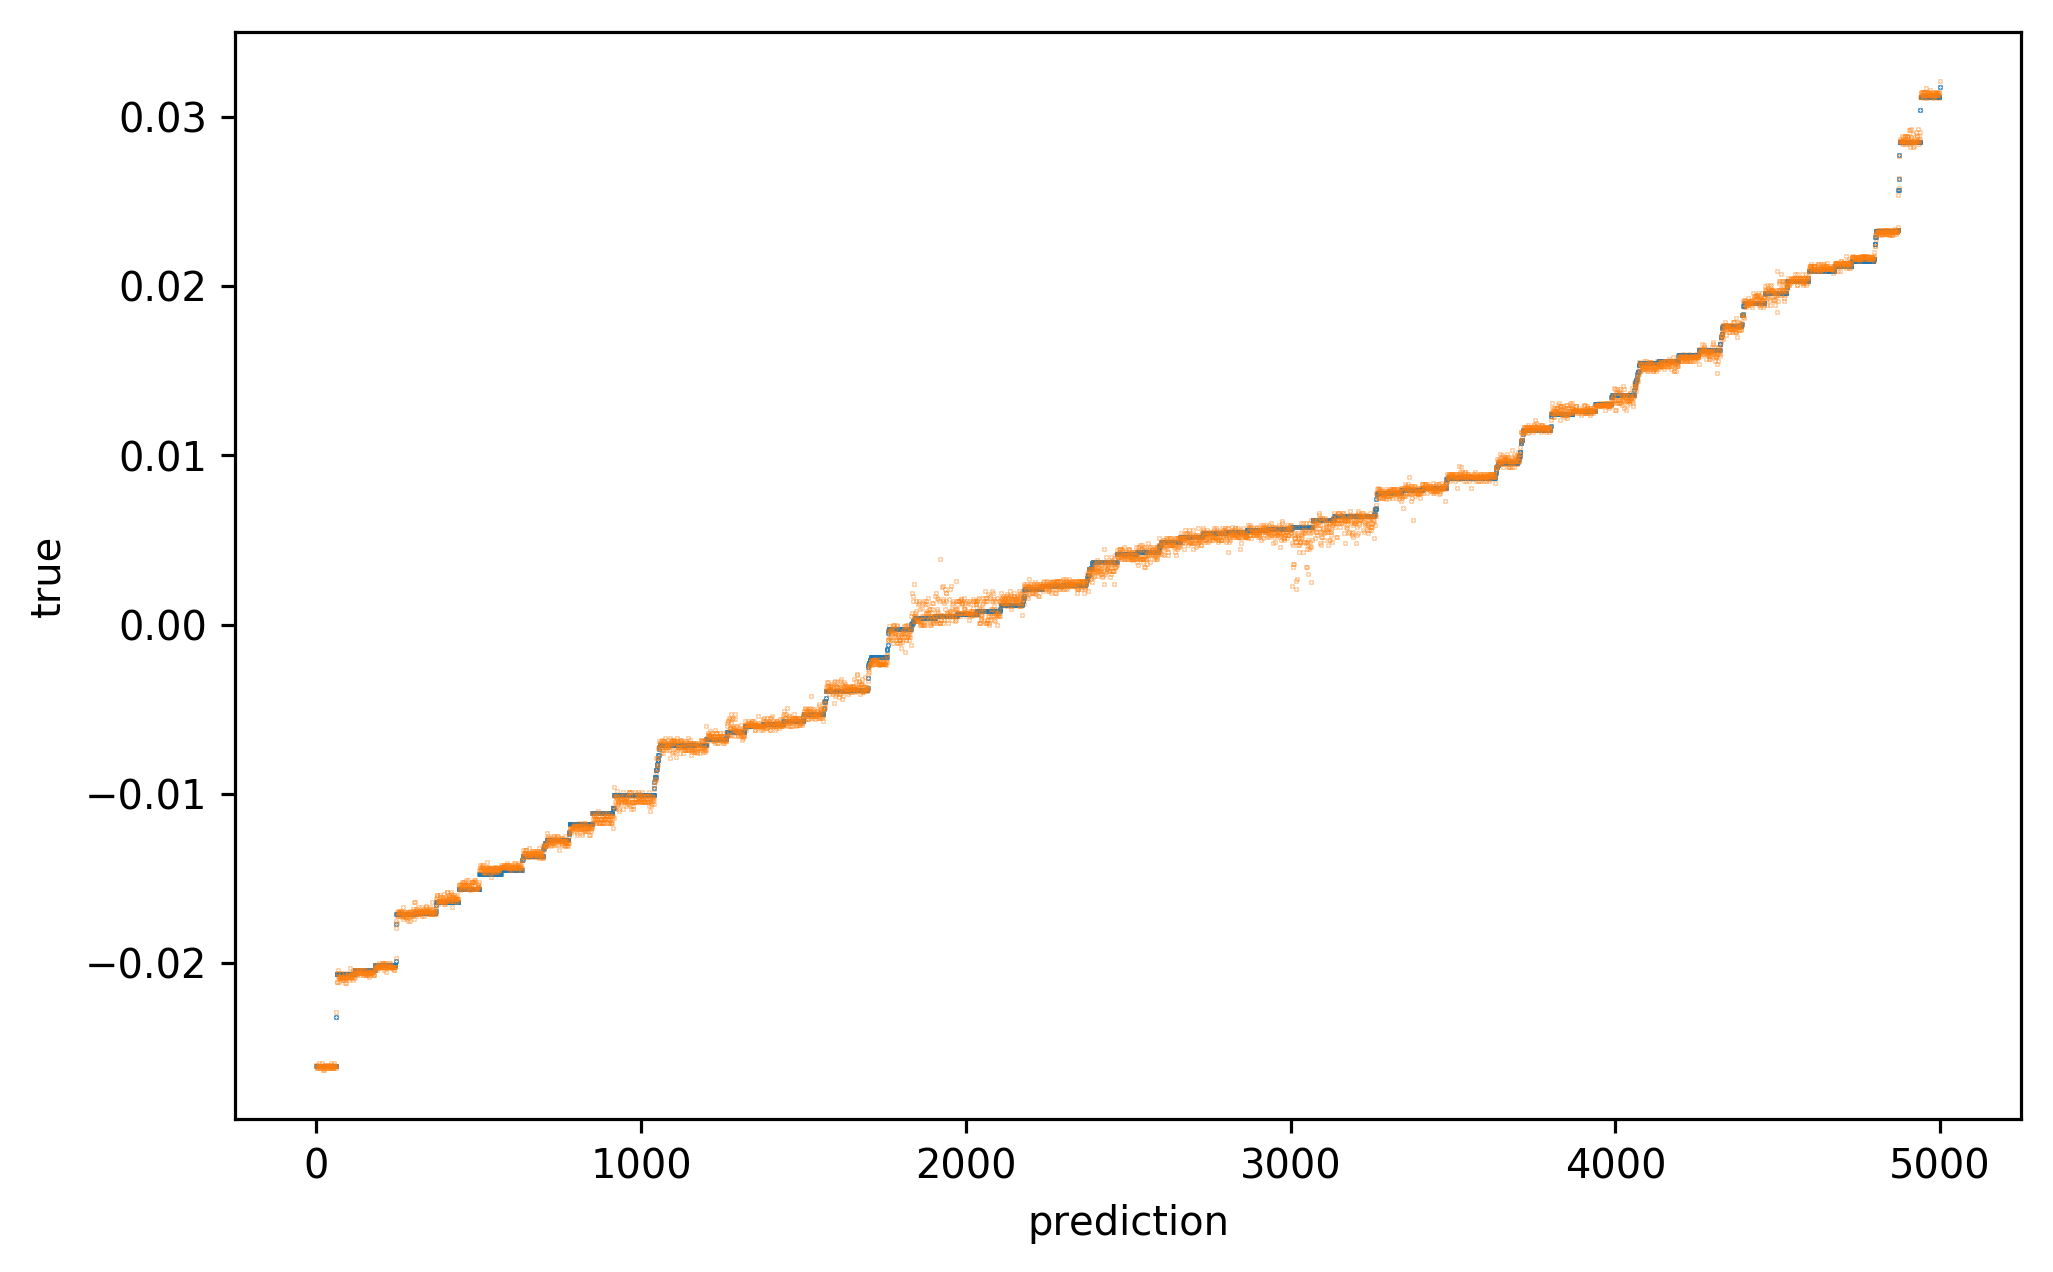

In [311]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 144)
idx = np.argsort(targets)
plt.plot(np.array(targets)[idx], ls = 'none', marker = 's', markersize = .1, alpha = 1)
plt.plot(np.array(best_guesses)[idx], ls = 'none', marker = 's', markersize = .1, alpha = 0.5)
# plt.xlim(-0.040, 0.040)
# plt.ylim(-0.040, 0.040)
plt.xlabel('prediction')
plt.ylabel('true');

***

## Assuming these results are ok, can we solve Ax = b and get realistic results?

In [362]:
# Create A
A = make_A_from_list_o_sep_pairs(evaluation_seps, max_ant )

### take a look at A.

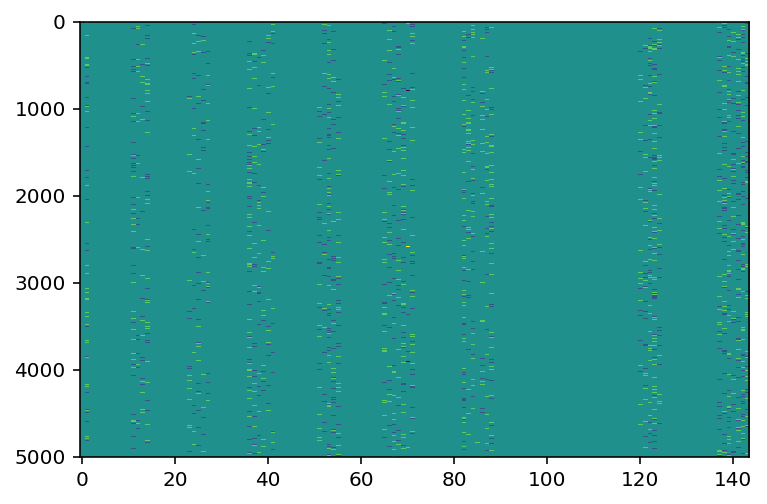

In [363]:
plt.imshow(A, aspect = 'auto');

In [364]:
# # drop the empty columns ( the antennas not present)
# # dont do and  indexing  will be easier
# A = A[:, unique_ants]

In [365]:
# create b
b = np.array(best_guesses)

In [366]:
np.array(trus).shape

(47,)

Solve Ax = b

In [367]:
b.shape

(5000,)

In [368]:
# solve
x = np.linalg.lstsq(A, np.array(targets), rcond=None)[0]

In [369]:
# suppress scientific notation
np.set_printoptions(suppress=True)

In [370]:
x

array([ 0.        , -0.00088047, -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.00014563,  0.00176412, -0.00005957, -0.00011039,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00030786,  0.00103387,
       -0.00028287,  0.00016698,  0.00057865, -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.00026086,  0.00093712,  0.0011245 ,  0.00029075,
       -0.00060042, -0.00031647, -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00055713, -0.0011548 , -0.00027809, -0.00191577,
       -0.00108072,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00085231, -0.00039542,  0.0007039 , -0.00105353,  0.00

In [371]:
x * 10000

array([  0.        ,  -8.80467698,  -0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,   1.45630125,
        17.64123934,  -0.59565679,  -1.10394741,   0.        ,
        -0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   3.07860772,
        10.33868608,  -2.82870008,   1.66979707,   5.78645633,
        -0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
        -2.60856898,   9.37123058,  11.24503069,   2.90750566,
        -6.00419082,  -3.16471822,  -0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -5.57133116,
       -11.54799156,  -2.78093729, -19.15774022, -10.8071827 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [372]:
solution = {i : x[i] for i in range(len(x))}

In [373]:
keys = sorted(generated_ant_delays.keys())
sols = [solution[key] for key in keys]
trus = [generated_ant_delays[key] for key in keys]
errs = np.array(trus) - np.array(sols)

In [374]:
print(np.std(errs))
print(np.mean(errs))
print(np.median(errs))

0.005780200697908683
0.0008398356153802806
0.0016184409051299125


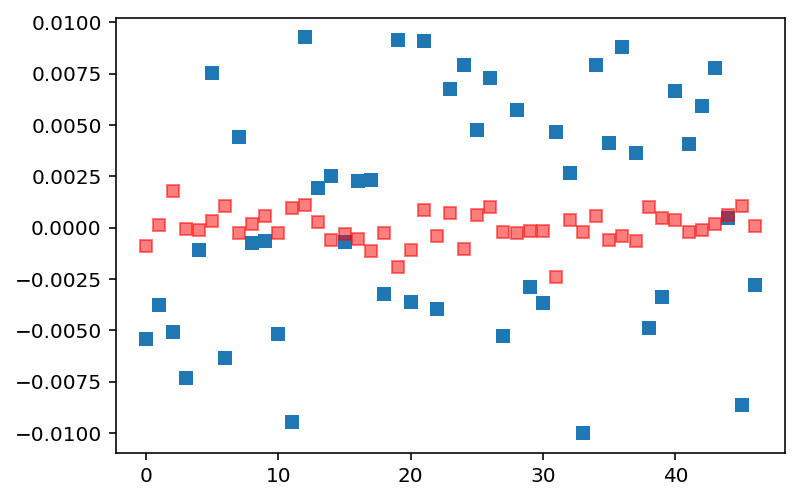

In [375]:
plt.plot(np.arange(len(sols)), trus,ls = 'none', marker = 's')
plt.plot(np.arange(len(sols)), sols,ls = 'none', marker = 's', c = 'r', alpha = 0.5)

Should we weight AX = b? if so by what?

***
combined_prob as Weights 🤷🏻‍♂️

Solve wAx = wb

In [273]:
w = np.diag(1/(np.array(combined_prob)))

In [274]:
wb = np.dot(w,b)

In [275]:
wA = np.dot(w,A)

In [276]:
wx = np.linalg.lstsq(wA, wb, rcond=None)[0]

In [320]:
wx * 10000

array([ -0.        ,  -1.32634206,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        , -12.28178891,
        -4.95539752,   7.91524673,   9.39277016,  -0.        ,
        -0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,  13.74219329,
        -7.46570139,  -0.24999414,   2.52273557,  -2.52914362,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,   0.        ,
        -2.44458392,   9.3367209 ,   3.93150203,  15.49909583,
        -6.19101431, -45.98542433,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,   9.6869475 ,
        17.5812453 ,   1.75014337, -20.37450981,  -1.14261684,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [278]:
solution = {i : wx[i] for i in range(len(wx))}

In [279]:
keys = sorted(generated_ant_delays.keys())
sols = [solution[key] for key in keys]
trus = [generated_ant_delays[key] for key in keys]
errs = np.array(trus) - np.array(sols)

In [280]:
print(np.std(errs))
print(np.mean(errs))
print(np.median(errs))

0.005644745023944202
0.0008398356153802813
0.0005583117210619932


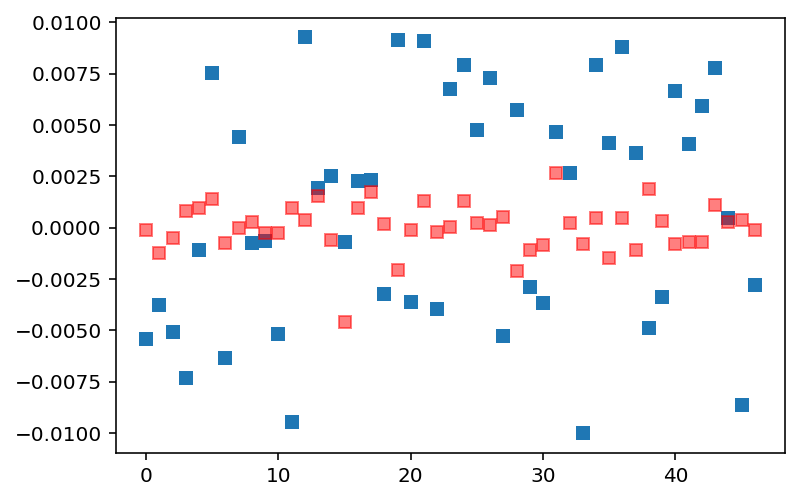

In [281]:
plt.plot(np.arange(len(sols)), trus,ls = 'none', marker = 's')
plt.plot(np.arange(len(sols)), sols,ls = 'none', marker = 's', c = 'r', alpha = 0.5)